In [165]:
import pandas_datareader.data as web
import numpy as np
import pandas as pd
import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from scipy.stats import probplot, moment

import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as finance

from scipy import stats

In [166]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w


#   Main Block started
class Generation:

    def __init__(self, based_symbol:str):
        self.based_symbol = based_symbol    #   Symbol storage
        self.symbol_data = finance.download(self.based_symbol, start='2012-01-01', end="2018-01-01") #  Reference data
        self.trend_line = None  #   Raw Trend
        self.trend_size = None  #   Raw Trend size
        self.walking = None #   Stochastic dataset
        self.final_trend_line = None    #   Buffer random walking
        self.final_size = None  #   Buffer random walking size
        self.final_with_std = None  #   Result of random walking algorithm
        self.final_size_std = None  #   Size result of random walking algorithm
        self.bootstrap_data = None  #   Raw dataset from bootstrap method
        self.combined_boot_trend = None #   All result

        self.collect_trend_line(info=False)
        plt.figure(figsize=(8,4))
        plt.plot(self.symbol_data["Open"])
        plt.title('Input Raw Data')
        plt.show()


    def collect_trend_line(self, info=True):
        """
        Takes trend line from time-series data. It will help me to make more real dataset. So first parameter is BASED SYMBOL
        *Possible to replace with moving average line*
        :return:
        """
        print('SHAPE INPUT', self.symbol_data.shape)
        trend_buffer = self.symbol_data["Open"].squeeze().dropna()
        trend_buffer = trend_buffer.asfreq('M')
        for _arrow_ in reversed(range(trend_buffer.shape[0] - 1)):
            if trend_buffer[_arrow_].astype(str) == 'nan':
                trend_buffer[_arrow_] = trend_buffer[_arrow_+1]

        if info:
            print(trend_buffer)

        components = tsa.seasonal_decompose(trend_buffer, model='additive')
        ts = (trend_buffer.to_frame('Original')
          .assign(Trend=components.trend)
          .assign(Residual=components.resid)).dropna()

        trend_buffer = ts["Trend"].asfreq('d')
        print("TREND LEN:", len(trend_buffer))
        for i in reversed(range(trend_buffer.shape[0])):
            if trend_buffer[i].astype(str) == 'nan':
               trend_buffer[i] = trend_buffer[i+1]
        self.trend_line = trend_buffer
        self.trend_size = self.trend_line.shape[0] - 1
        del trend_buffer
        del components

    @classmethod
    def random_walking(cls, discrete_steps:int, continuous_steps:int, increment:float or int):
        """
        I will use it to create F(time) to input at NORMAL(TREND(time), F(time)).
        I make this in case that market time-series is not stationary row
        So this thing gives me ability to make STD function not equal in time
        :param discrete_steps: Usually will be int(365)
        :param continuous_steps:
        :param increment: STD parameter. At this step it is the most interesting parameter
        :return:
        """
        dt = 1 * continuous_steps / discrete_steps
        random_increment = np.random.normal(.0, increment, discrete_steps) * np.sqrt(dt)
        motion = np.cumsum(random_increment)
        motion = np.insert(motion, 0 , 0.0)
        return motion, random_increment


    def create_random_walking_line(self, info=True, show=True):
        """
        :param info: Print info about random array
        :param show: Show graphic
        :return:
        """
        motion_average_control = 7
        zero_log_control = 5


        self.walking = moving_average(np.log(abs(Generation.random_walking(discrete_steps=self.trend_size + motion_average_control + zero_log_control, continuous_steps=1,
                                                 increment=2)[0])[5:]), motion_average_control + 1)
        if info:
            print(f"--------\nMEAN: {self.walking.mean()}\nSTD: {self.walking.std()}")
        if show:
            plt.figure(figsize=(12,6))
            plt.grid()
            plt.plot(self.walking)
            plt.title('Random Walking')
            plt.show()


    def generate_new_trend_based_on_input(self, info=True, show=True):


        ### Not to change. Really dont touch it. Only few parameter, but better dont touch em too

        average_approx_strength = 25 #  High strength parameter

        frame = self.trend_line.to_frame()
        frame["Walk"] = self.walking
        frame.columns = ['Trend', 'Walk']

        if show:
            plt.figure(figsize=(18,6))
            plt.title("Adding walk component to reference trend")
            plt.plot(frame["Trend"] + abs(np.cumsum((frame["Walk"]))))
            plt.show()

        move = moving_average(frame["Trend"] + abs(np.cumsum((frame["Walk"]))), average_approx_strength)
        move = np.hstack((move, move[-(average_approx_strength - 1):]))

        frame["NORM"] = move

        if info:
            print(len(self.walking))
            print(len(frame))
            print(move)

        self.final_trend_line = frame.NORM[:-average_approx_strength]
        self.final_size = len(frame) - average_approx_strength
        if show:
            plt.figure(figsize=(18, 6))
            plt.title("MOVING AVERAGE: Adding walk component to reference trend")
            plt.plot(self.final_trend_line)
            plt.show()
        del frame
        del move

    def create_std_final_trend(self, show=True, weight = [.8, .2]):
        """

        :param show:
        :param weight: way to control how interesting result will be. I took that numbers to create something like reference
        :return:
        """
        average_approx_strength = 10 #  High strength parameter


        # FIXME:    Bad algorithm in new_array creation. Sometimes in creates huge volatility
        random = abs(Generation.random_walking(discrete_steps=self.final_size, continuous_steps=1, increment=70)[0][1:])
        new_array = []
        trend = self.final_trend_line
        for i in range(len(random)):
            new_array.append(weight[0] * trend[i] * weight[1] * 100 * random[i])

        new_array = moving_average(new_array, average_approx_strength) #    Problem solution is to use moving average
        #   May create some problems

        normalize_coff = max(new_array) / max(trend)
        #normalize_coff = new_array[0] / max(self.symbol_data["Open"])
        new_array = np.array(new_array) / normalize_coff

        new_array = new_array + stats.norm(100, 50).rvs()
        #   stats.norm is: Simple way to set not_zero_start
        #   It will help me to create sync bootstrap method

        if show:
            fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(12,6))
            ax[0].set_title('TREND_LINE')
            ax[0].plot(self.final_trend_line.values)
            ax[1].set_title('TREND WITH STD')
            ax[1].plot(new_array)
            ax[2].set_title('REFERENCE LINE')
            ax[2].plot(self.symbol_data["Open"][:self.final_size].values)

        self.final_with_std = new_array
        self.final_size_std = len(new_array)

    #   BLOCK WITH BOOTSTRAP METHOD
    def make_bootstrap_data(self, show=True, info=False):
        start_price = self.final_with_std[0]
        all_samples = self.symbol_data["Open"].pct_change().dropna()
        if info:
            print("START PRICE:", start_price)
            print(all_samples)
        prices = list()
        for _arrow_ in range(self.final_size_std):
            start_price *= (1 + np.random.choice(all_samples))
            prices.append(start_price)
        prices = prices / max(prices)
        if show:
            plt.figure(figsize=(12,4))
            plt.title('Bootstrap graph')
            plt.plot(prices)
            plt.show()
        self.bootstrap_data = prices

    def combine_trend_bootstrap(self, show=True, weights=[0.75, 0.25]):
        boot_trend = self.final_with_std * weights[0]  * weights[1] * (self.bootstrap_data / max(self.bootstrap_data))
        boot_trend = boot_trend / (boot_trend[0] / self.final_with_std[0])
        #boot_trend = boot_trend / (max(boot_trend) / max(self.symbol_data["Open"].values))
        boot_trend = boot_trend / (boot_trend.mean() / self.symbol_data["Open"].values.mean())
        if show:
            plt.figure(figsize=(12, 4))
            plt.title("SYNTH DATA")
            plt.plot(boot_trend)
            plt.show()
            plt.figure(figsize=(12, 4))
            plt.title("REAL DATA")
            plt.plot(self.symbol_data["Open"].values[:self.final_size_std])
            plt.show()

        self.combined_boot_trend = abs(boot_trend)

#   Main Block end

459
[*********************100%***********************]  1 of 1 completed
SHAPE INPUT (1495, 6)
TREND LEN: 1766


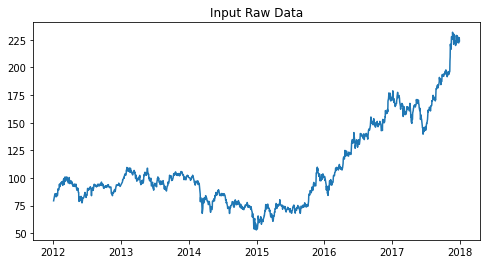

In [167]:
SEED = np.random.randint(0, 1000) # Generates case i want to fix
print(SEED)
sber = Generation('SBER.ME')
#sber = Generation('NVDA')

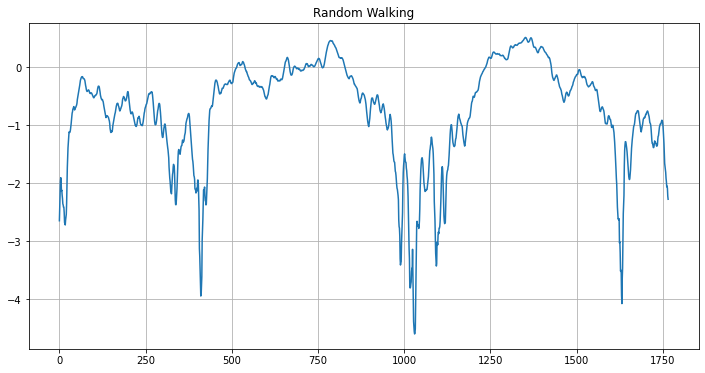

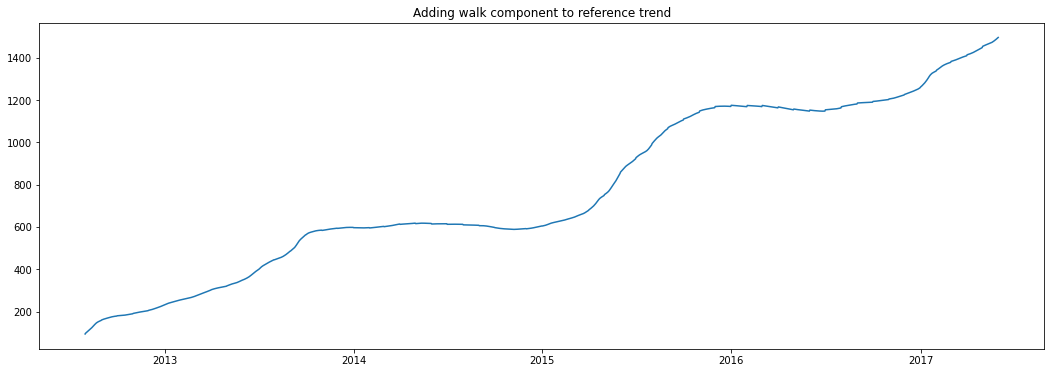

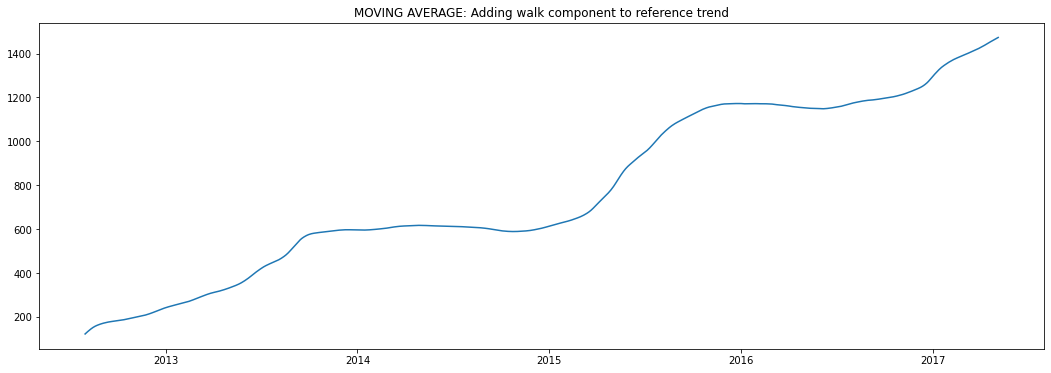

In [168]:
np.random.seed(SEED)
#   Make this until we get what we likes
sber.create_random_walking_line(info=False, show=True)

#   Generate unique trend based little by reference
sber.generate_new_trend_based_on_input(info=False)

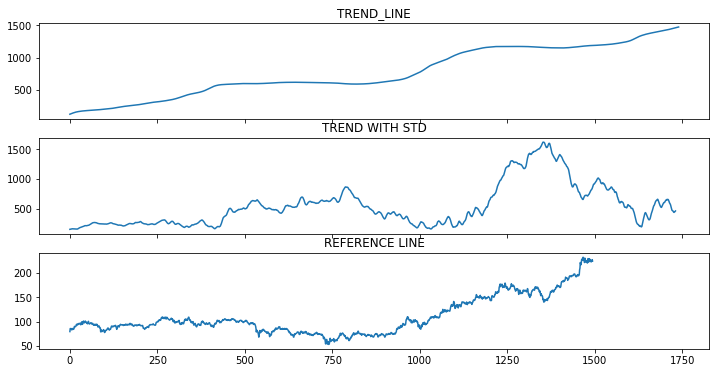

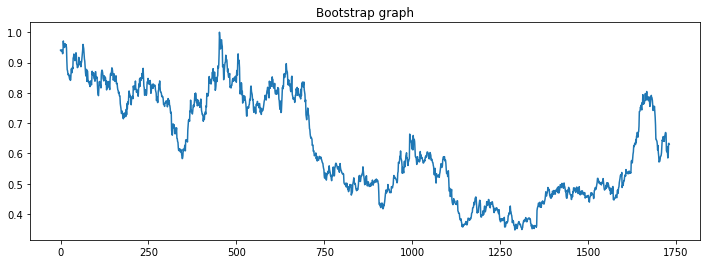

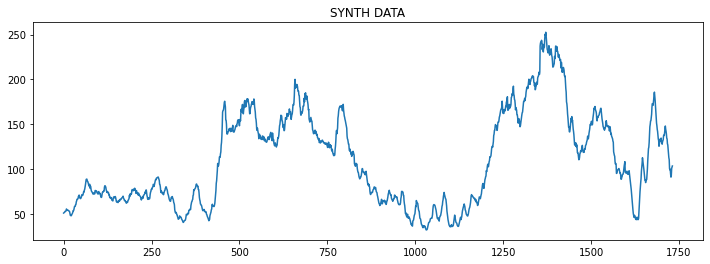

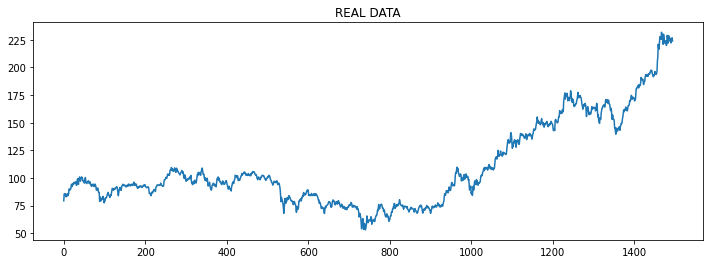

SYNTH STD: 51.54140757230544
REAL STD: 38.531953549781704


In [169]:
np.random.seed(SEED)
#   Apply STD function to trend. Be careful sometimes works wrong #FIXED
sber.create_std_final_trend()

#   Starting Bootstrap method
sber.make_bootstrap_data()

#   Combining
sber.combine_trend_bootstrap()

print("SYNTH STD:", sber.combined_boot_trend.std())
print("REAL STD:", sber.symbol_data["Open"].values[:sber.final_size_std].std())

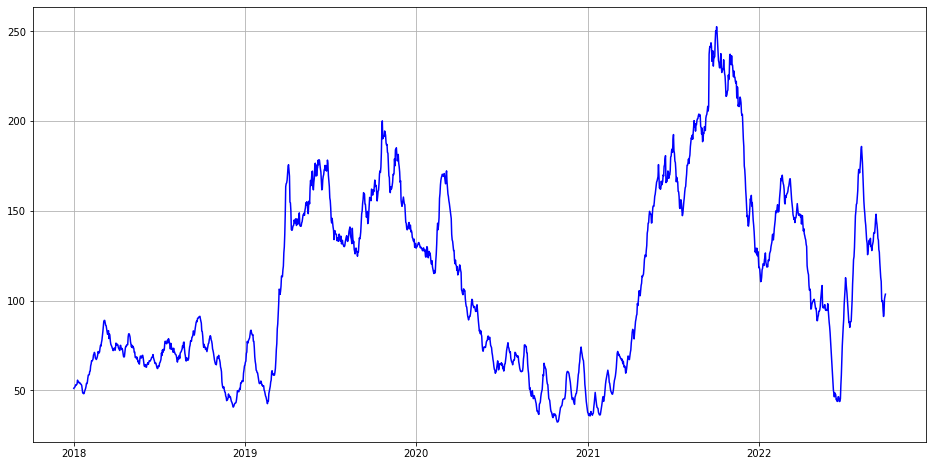

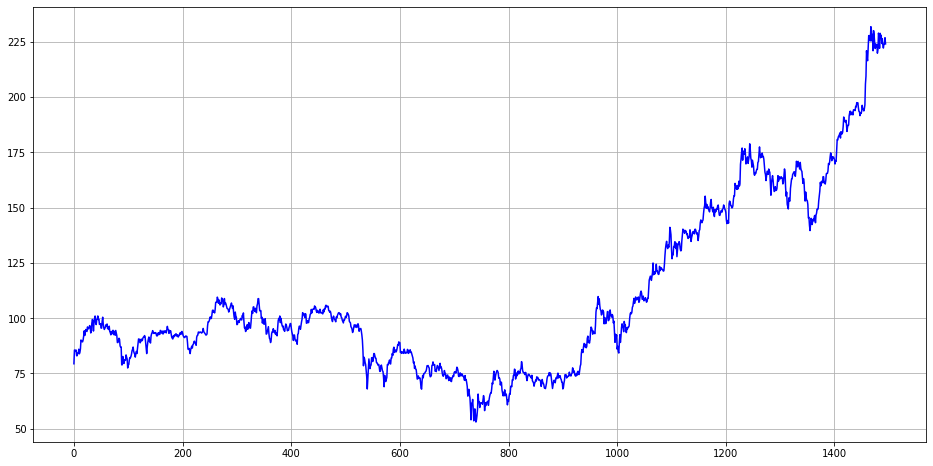

In [170]:
np.random.seed(SEED)
testing = pd.DataFrame(sber.combined_boot_trend, index=pd.date_range("2018-01-01", periods=len(sber.combined_boot_trend), freq="d"))
plt.figure(figsize=(16,8))
plt.grid()
plt.plot(testing, color='blue')
plt.savefig("test.png")
plt.show()
plt.figure(figsize=(16,8))
plt.grid()
plt.plot(sber.symbol_data["Open"].values, color='blue')
plt.show()

In [171]:
np.random.seed(SEED)
sber.final_with_std.std()
## BAD GRAPH STD = 144

352.3313455474696

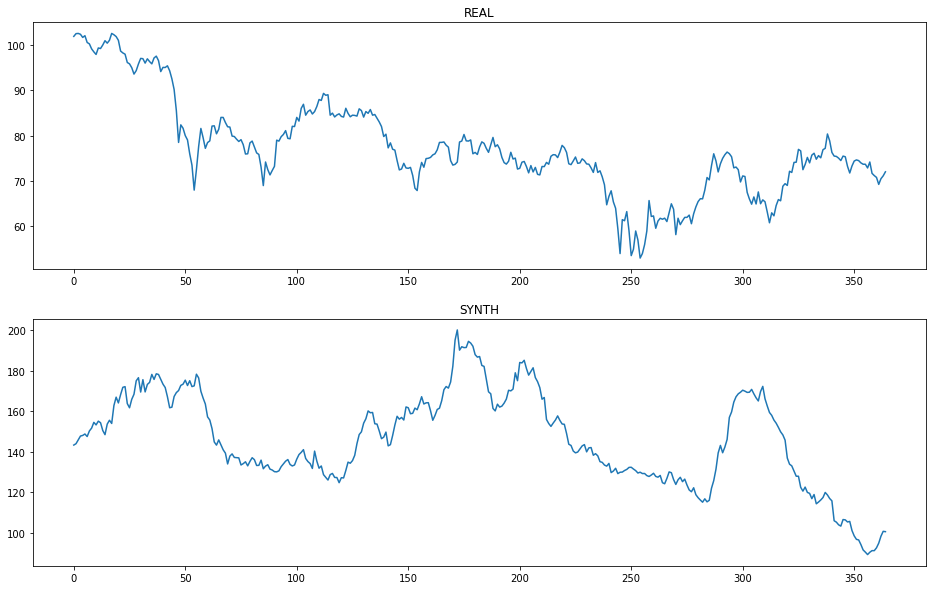

In [210]:
#np.random.seed(SEED)
LEN_DATASET = 365
idx = np.random.randint(0, len(sber.symbol_data["Open"].values) - LEN_DATASET)
plt.figure(figsize=(16,10))
plt.subplot(2,1,1)
plt.title('REAL')
plt.plot(sber.symbol_data['Open'].values[idx:idx+LEN_DATASET])
plt.subplot(2,1,2)
plt.title('SYNTH')
plt.plot(sber.combined_boot_trend[idx:idx+LEN_DATASET])